<a href="https://colab.research.google.com/github/TrayambakShrivastava/DocumentClassifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'
# !pip install torchvision tesseract
# # Install Tesseract OCR
# !apt-get install tesseract-ocr
# # Install PyTesseract and Pillow
# !pip install pytesseract Pillow
# !pip install transformers
# os.kill(os.getpid(), 9)

In [3]:
#Install dataset
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00


In [4]:
#imports
import os
from transformers import LayoutLMv2ImageProcessor, LayoutLMv2TokenizerFast, LayoutLMv2Processor
from transformers import LayoutLMv2Config, LayoutLMv2Model
from transformers import LayoutLMv2ForSequenceClassification
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imghdr
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import Features, Array3D, Sequence, Value, Array2D, ClassLabel
from transformers import AdamW
import torch
from tqdm import tqdm




In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# from transformers import LayoutLMv2ImageProcessor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

image_processor = LayoutLMv2ImageProcessor()  # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(image_processor, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [8]:
# from PIL import Image

# **PROCESSOR TESTING ON A RANDOM IMAGE**

In [9]:
img_path ='/content/drive/MyDrive/test_invite.jpeg'

In [10]:
img = Image.open(img_path)

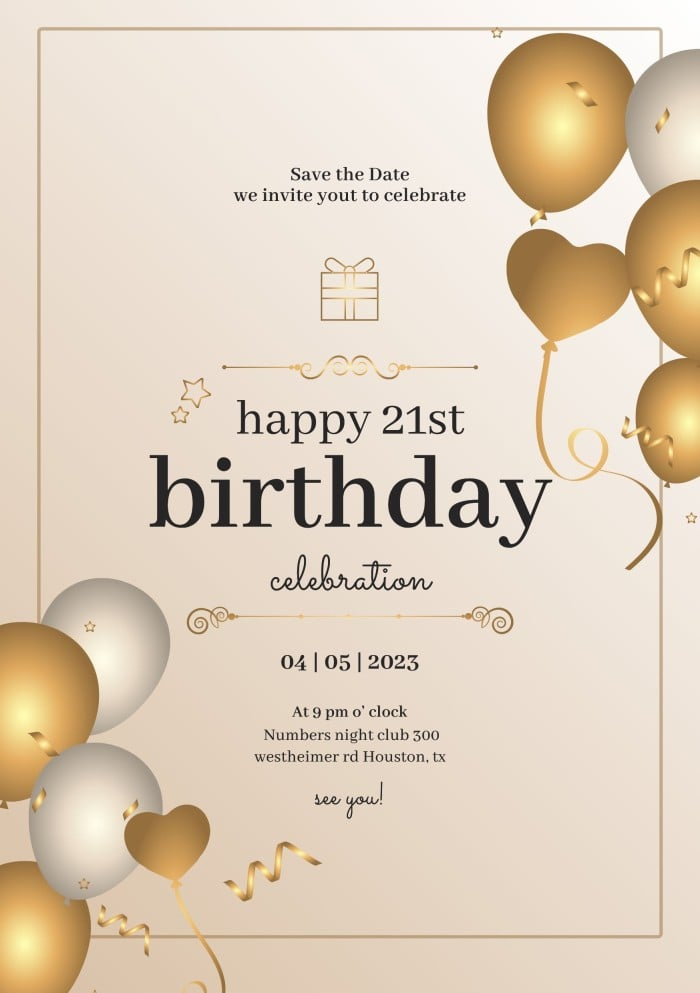

In [11]:
img

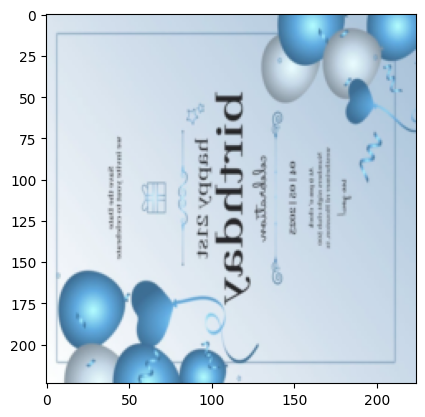

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_encoding = image_processor(images = img)
img_encoding.keys()


# Display the image
#plt.imshow(img_encoding['pixel_values'][0][0].transpose())
#plt.imshow(img_encoding['pixel_values'][0][1].transpose())
#plt.imshow(img_encoding['pixel_values'][0][2].transpose())
plt.imshow(img_encoding['pixel_values'][0].transpose())
plt.show()


In [13]:
#writing the words understood by ocr
img_encoding['words']

[['Save',
  'the',
  'Date',
  'we',
  'invite',
  'yout',
  'to',
  'celebrate',
  '+',
  '20',
  '>',
  'e',
  'happy',
  '21st',
  '04',
  '|',
  '05',
  '|',
  '2023',
  'Atg',
  'pmo’',
  'clock',
  'Numbers',
  'night',
  'club',
  '300',
  'westheimer',
  'rd',
  'Houston,',
  'tx',
  'opel',
  'i>']]

# **RETRIEVING CUSTOM DATASET**

In [14]:
# from zipfile import ZipFile
# file_name = '/content/dataset.zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

# ***ENTER DATA SET PATH***

In [15]:
dataset_path = "/content/drive/MyDrive/dataset"

In [16]:
def count_exp(path):
    c = {}
    for expression in os.listdir(path):
        class_path = os.path.join(path, expression)

        # Check if it's a directory before trying to list its contents
        if os.path.isdir(class_path):
            c[expression] = len(os.listdir(class_path))

    df = pd.DataFrame(c, index=["count"])
    return df


In [17]:
def delete_dsstore_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Replace 'your_directory_path' with the actual path to your directory
your_directory_path = dataset_path
delete_dsstore_files(your_directory_path)


In [18]:
count = count_exp(dataset_path)
print(count)

       government  legal  medical  finance  news  educational  \
count          70     68       18       75    28           20   

       scientific research  business  technical manuals  creative writing  
count                   55        16                 23                22  


<Axes: >

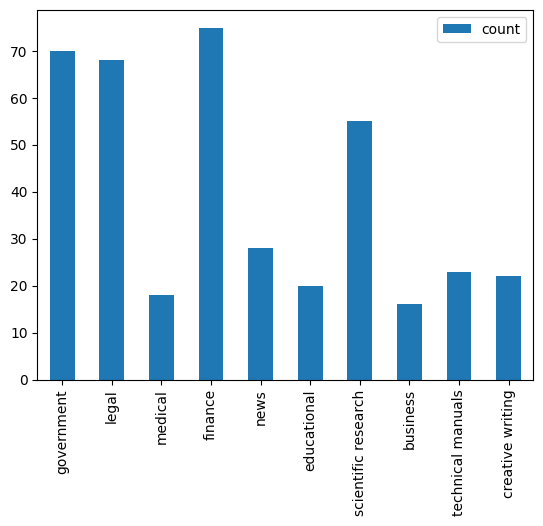

In [19]:
count.transpose().plot(kind='bar')

In [20]:
# Get a list of label names from the directories in dataset_path
label_names = [label for label in os.listdir(dataset_path)]

# Create a dictionary mapping numerical identifiers to label names
id_to_label = {index: label for index, label in enumerate(label_names)}

# Create a dictionary mapping label names to numerical identifiers
label_to_id = {label: index for index, label in enumerate(label_names)}

# Remove the entry associated with '.DS_Store' from label_to_id
label_to_id.pop('.DS_Store', None)

# Print the resulting label-to-id mapping
print(label_to_id)

{'government': 0, 'legal': 1, 'medical': 2, 'finance': 3, 'news': 4, 'educational': 5, 'scientific research': 6, 'business': 7, 'technical manuals': 8, 'creative writing': 9}


In [21]:
# Replace 'your_dataset_path' with the actual path to your dataset
your_dataset_path = dataset_path
# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Walk through the dataset path
for label_folder, _, file_names in os.walk(your_dataset_path):
    if label_folder != your_dataset_path:
        # Extract the label from the folder path
        label = label_folder.split("/")[-1]

        # Construct relative image paths and append to the 'image_paths' list
        relative_image_paths = [os.path.join(your_dataset_path, label, image_file) for image_file in file_names]
        image_paths.extend(relative_image_paths)

        # Append corresponding labels to the 'labels' list
        labels.extend([label] * len(relative_image_paths))

# Create a Pandas DataFrame from the lists of image paths and labels
dataset = pd.DataFrame.from_dict({'image_path': image_paths, 'label': labels})

# Extract unique labels from the 'labels' list
unique_labels = list(set(labels))

# Display the first few rows of the DataFrame
dataset

,image_path,label
0,/content/drive/MyDrive/dataset/government/1.jpeg,government
1,/content/drive/MyDrive/dataset/government/2.jpg,government
2,/content/drive/MyDrive/dataset/government/3.jpeg,government
3,/content/drive/MyDrive/dataset/government/4.jpeg,government
4,/content/drive/MyDrive/dataset/government/6.jpeg,government
...,...,...
390,/content/drive/MyDrive/dataset/creative writin...,creative writing
391,/content/drive/MyDrive/dataset/creative writin...,creative writing
392,/content/drive/MyDrive/dataset/creative writin...,creative writing
393,/content/drive/MyDrive/dataset/creative writin...,creative writing


In [22]:
dataset.shape

(395, 2)

In [23]:
def is_image_corrupt(file_path):
    try:
        # Attempt to open the image
        img = Image.open(file_path)
        # Check if the image can be loaded successfully
        img.verify()
        return False  # Image is not corrupt
    except (IOError, SyntaxError):
        return True  # Image is corrupt

def find_corrupt_images(directory):
    corrupt_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image_corrupt(file_path):
                corrupt_images.append(file_path)
    return corrupt_images

# Replace 'your_directory_path' with the actual path to your image directory
your_directory_path = dataset_path

corrupt_images_list = find_corrupt_images(your_directory_path)

if corrupt_images_list:
    print("Corrupt images found:")
    for corrupt_image in corrupt_images_list:
        print(corrupt_image)
else:
    print("No corrupt images found.")


No corrupt images found.


In [24]:
def delete_corrupt_images(corrupt_images):
    for corrupt_image in corrupt_images:
        try:
            # Attempt to remove the corrupt image file
            os.remove(corrupt_image)
            print(f"Deleted: {corrupt_image}")
        except Exception as e:
            print(f"Error deleting {corrupt_image}: {e}")

In [25]:
delete_corrupt_images(corrupt_images_list)

# REDECLARING DATASET AFTER REMOVING CORRUPTED IMAGE FILES


In [26]:
# Replace 'your_dataset_path' with the actual path to your dataset
your_dataset_path = dataset_path
# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Walk through the dataset path
for label_folder, _, file_names in os.walk(your_dataset_path):
    if label_folder != your_dataset_path:
        # Extract the label from the folder path
        label = label_folder.split("/")[-1]

        # Construct relative image paths and append to the 'image_paths' list
        relative_image_paths = [os.path.join(your_dataset_path, label, image_file) for image_file in file_names]
        image_paths.extend(relative_image_paths)

        # Append corresponding labels to the 'labels' list
        labels.extend([label] * len(relative_image_paths))

# Create a Pandas DataFrame from the lists of image paths and labels
dataset = pd.DataFrame.from_dict({'image_path': image_paths, 'label': labels})

# Extract unique labels from the 'labels' list
unique_labels = list(set(labels))

# Display the first few rows of the DataFrame
dataset

,image_path,label
0,/content/drive/MyDrive/dataset/government/1.jpeg,government
1,/content/drive/MyDrive/dataset/government/2.jpg,government
2,/content/drive/MyDrive/dataset/government/3.jpeg,government
3,/content/drive/MyDrive/dataset/government/4.jpeg,government
4,/content/drive/MyDrive/dataset/government/6.jpeg,government
...,...,...
390,/content/drive/MyDrive/dataset/creative writin...,creative writing
391,/content/drive/MyDrive/dataset/creative writin...,creative writing
392,/content/drive/MyDrive/dataset/creative writin...,creative writing
393,/content/drive/MyDrive/dataset/creative writin...,creative writing


In [27]:
dataset.shape

(395, 2)

In [28]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optionally, turn off axis labels
    plt.show()

# Example usage
# image_path = 'path/to/your/image.jpg'
# show_image(image_path)


In [29]:
def is_png(file_path):
    image_type = imghdr.what(file_path)
    return image_type

# Example usage
# image_path = '/content/dataset/medical/19.png'
# print(is_png(image_path))


In [30]:
#  show_image('/content/dataset/medical/19.webp')

       government  legal  medical  finance  news  educational  \
count          70     68       18       75    28           20   

       scientific research  business  technical manuals  creative writing  
count                   55        16                 23                22  


<Axes: >

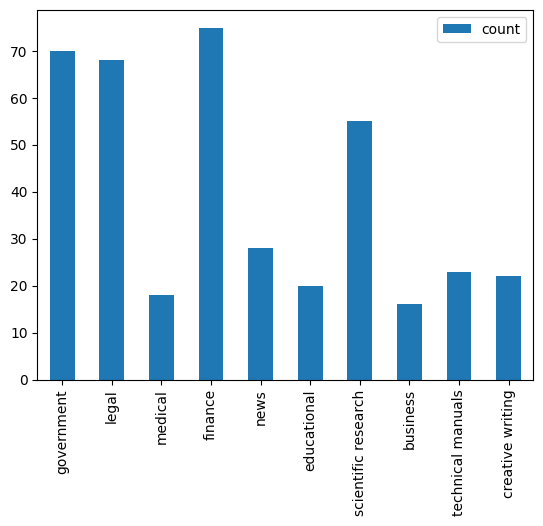

In [31]:
count = count_exp(dataset_path)
print(count)
count.transpose().plot(kind='bar')

In [32]:
# Get a list of label names from the directories in dataset_path
label_names = [label for label in os.listdir(dataset_path)]

# Create a dictionary mapping numerical identifiers to label names
id_to_label = {index: label for index, label in enumerate(label_names)}

# Create a dictionary mapping label names to numerical identifiers
label_to_id = {label: index for index, label in enumerate(label_names)}

# Remove the entry associated with '.DS_Store' from label_to_id
label_to_id.pop('.DS_Store', None)

# Print the resulting label-to-id mapping
print(label_to_id)

{'government': 0, 'legal': 1, 'medical': 2, 'finance': 3, 'news': 4, 'educational': 5, 'scientific research': 6, 'business': 7, 'technical manuals': 8, 'creative writing': 9}


In [33]:
# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print the size of each split
print(f"Train set size: {len(train_data)} samples")
print(f"Validation set size: {len(val_data)} samples")
print(f"Test set size: {len(test_data)} samples")

# # Optional: Save the split datasets to CSV files
# train_data.to_csv(os.path.join(your_dataset_path, 'train.csv'), index=False)
# val_data.to_csv(os.path.join(your_dataset_path, 'validation.csv'), index=False)
# test_data.to_csv(os.path.join(your_dataset_path, 'test.csv'), index=False)


Train set size: 284 samples
Validation set size: 32 samples
Test set size: 79 samples


In [34]:
train_data.head()

,image_path,label
148,/content/drive/MyDrive/dataset/medical/11.png,medical
295,/content/drive/MyDrive/dataset/scientific rese...,scientific research
392,/content/drive/MyDrive/dataset/creative writin...,creative writing
54,/content/drive/MyDrive/dataset/government/imag...,government
274,/content/drive/MyDrive/dataset/educational/16.png,educational


In [35]:
train_data_hf = Dataset.from_pandas(train_data)
test_data_hf = Dataset.from_pandas(test_data)


In [36]:
test_data_hf

Dataset({
    features: ['image_path', 'label', '__index_level_0__'],
    num_rows: 79
})

In [37]:
# feature_extractor = LayoutLMv2FeatureExtractor()
# tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
# processor = LayoutLMv2Processor(feature_extractor, tokenizer)

input_size = 224
ch = 3


# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(ch, input_size, input_size)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(unique_labels), names=unique_labels),
})

# # we need to define custom features
# features = Features({
#     'image': Array3D(dtype="int64", shape=(ch, input_size, input_size)),
#     'input_ids': Sequence(feature=Value(dtype='int64')),
#     'attention_mask': Sequence(Value(dtype='int64')),
#     'token_type_ids': Sequence(Value(dtype='int64')),
#     'bbox': Array2D(dtype="int64", shape=(512, 4)),
#     'labels': ClassLabel(num_classes=len(labels), names=labels),
# })

DEFINING A PREPROCESSING FUNCTION

In [38]:
dataset_path


'/content/drive/MyDrive/dataset'

In [39]:
#creating path to images
image_path = dataset_path

In [40]:
def preprocess_data(examples):
    # take a batch of images
    images = [Image.open(path).convert("RGB")
              for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)

    # add labels
    encoded_inputs["labels"] = [label_to_id[label] for label in examples["label"]]

    return encoded_inputs

In [41]:
# Encoding Training Dataset
train_encoded_data_custom = train_data_hf.map(
    preprocess_data,
    remove_columns=train_data_hf.column_names,
    features=features,  # Assuming you have a custom_features variable instead of features
    batched=True,
    batch_size=8
)

train_encoded_data_custom.set_format(type="torch")


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [42]:
# Encoding Test Dataset
test_encoded_data_custom = test_data_hf.map(
    preprocess_data,
    remove_columns=test_data_hf.column_names,
    features=features,
    batched=True,
    batch_size=4
)

test_encoded_data_custom.set_format(type="torch")


Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [43]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import pickle

# # Save your variables to Google Drive
# with open('/content/gdrive/My Drive/variables.pkl', 'wb') as f:
#     pickle.dump(train_encoded_data_custom, f)
#     pickle.dump(test_encoded_data_custom, f)




In [44]:
# # Load variables from Google Drive
# with open('/content/drive/MyDrive/variables.pkl', 'rb') as f:
#     train_encoded_data_custom_loaded = pickle.load(f)
#     test_encoded_data_custom_loaded = pickle.load(f)

In [45]:
train_dataloader = torch.utils.data.DataLoader(train_encoded_data_custom, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_encoded_data_custom, batch_size=4)

In [46]:
num_labels = len(unique_labels)
model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", num_labels=num_labels)
model.to(device)

# Accessing the model configuration
configuration = model.config


pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
epochs = 7

In [48]:
def train(model, dataloader, optimizer,device="cuda"):
    model.train()
    pbar = tqdm(dataloader)
    correct = 0
    total_loss = 0
    progress = 0
    for batch_idx, batch in enumerate(pbar):
        batch['labels'] = batch['labels'].to(device)
        batch['image'] = batch['image'].to(device)
        # print(batch['image'])
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['token_type_ids'] = batch['token_type_ids'].to(device)
        batch['bbox'] = batch['bbox'].to(device)
        optimizer.zero_grad()

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predictions = outputs.logits.argmax(-1)
        correct += (predictions == batch['labels']).float().sum()
        total_loss += loss.item()
        progress += batch["input_ids"].shape[0]

        pbar.set_description(
            desc=f'batch_id={batch_idx} loss={total_loss / (batch_idx+1):.4f} acc={100 * correct / progress:.2f} %')


def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    iteration = 0
    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            batch['labels'] = batch['labels'].to(device)
            batch['image'] = batch['image'].to(device)
            print(batch['image'])
            batch['input_ids'] = batch['input_ids'].to(device)
            batch['attention_mask'] = batch['attention_mask'].to(device)
            batch['token_type_ids'] = batch['token_type_ids'].to(device)
            batch['bbox'] = batch['bbox'].to(device)
            outputs = model(**batch)
            loss = outputs.loss

            total_loss += loss.item()
            predictions = outputs.logits.argmax(-1)
            correct += (predictions == batch['labels']).float().sum()
            iteration += 1

    accuracy = 100 * correct / len(dataloader.dataset)
    print("loss: {:.4f} \t Accuracy: {:.2f} %\n".format(
        total_loss / iteration, accuracy.item()))

In [49]:
# # Save the model to Google Drive
# model_save_path = '/content/gdrive/My Drive/model.pth'
# torch.save(model.state_dict(), model_save_path)
model_save_path = "/content/drive/MyDrive/final_model.pt"  # Set the file path here

In [50]:
optimizer = AdamW(model.parameters(), lr=5e-5)

# Number of epochs
epochs = epochs

for epoch in range(epochs):
    print("Epoch: ",epoch)
    train(model, train_dataloader, optimizer)
    evaluate(model, test_dataloader)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:  0


batch_id=70 loss=1.9239 acc=30.28 %: 100%|██████████| 71/71 [01:36<00:00,  1.36s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=1.3410 acc=53.87 %: 100%|██████████| 71/71 [01:38<00:00,  1.38s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=1.0557 acc=64.08 %: 100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=0.9482 acc=72.89 %: 100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=0.8017 acc=77.46 %: 100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=0.5905 acc=84.86 %: 100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

batch_id=70 loss=0.5307 acc=84.86 %: 100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]],


        [[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255

In [51]:
def infer(image, id2label, model, processor):
    # prepare image for the model
    encoded_inputs = processor(image, return_tensors="pt")

    # forward pass
    encoded_inputs.to(device)
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

    # map predicted index to label using id2label dictionary
    predicted_label = id2label[predicted_class_idx]

    return predicted_label


In [52]:
# num_test = 8
# cnt = 1

# plt.figure(figsize=(20,50))
# while cnt<=8:
#     k = np.random.randint(len(test_data))
#     label = test_data.label.iloc[k]
#     im = Image.open(test_data.image_path.iloc[k]).convert("RGB")
#     try:
#         pred = infer(im, id_to_label, model, processor)
#     except Exception as e:
#         continue

#     plt.subplot(int(num_test/2),2,cnt)
#     plt.imshow(im)
#     plt.axis('off')
#     plt.title(f"Label: {label}\n Pred: {pred}")
#     cnt += 1

# plt.show()


EDITING THE INFERENCE TO ACCEPT PAGINATED INPUT

In [53]:
def split_into_pages(pdf_doc_path):
  doc = fitz.open(pdf_doc_path)
  pages = [page for page in doc.pages()]
  return pages

In [54]:
import statistics

def inference_mul(images, id2label, model, processor):
    pages = images
    all_pred = []

    for page in pages:
        encoded_inputs = processor(page, return_tensors="pt")
        outputs = model(**encoded_inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predicted_label = id2label[predicted_class_idx]
        all_pred.append(predicted_label)

    # forward pass
    encoded_inputs.to(device)
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

    # map predicted index to label using id2label dictionary
    predicted_label = id2label[predicted_class_idx]

    # Calculate the most common prediction (mode)
    average_pred = statistics.mode(all_pred)

    return average_pred




In [55]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 16.2 MB/s eta 0:00:00


In [56]:
import fitz

In [57]:
i = 2

In [58]:
pdf_path = '/content/drive/MyDrive/Test Data/1.pdf'

In [59]:
!pip install pdf2image Pillow torchvision
!apt-get install -y poppler-utils
!apt-get install -y libpoppler-cpp-dev
!pip install pdf2image Pillow torchvision

ERROR: Operation cancelled by user
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (333 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121796 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  li

In [60]:
from pdf2image import convert_from_path
from PIL import Image
import torchvision.transforms as transforms
import torch

def pdf_to_tensor(pdf_path):
    # Convert PDF pages to images using pdf2image
    images = convert_from_path(pdf_path)

    # Initialize an empty list to store the PyTorch tensors
    page_tensors = []

    for img in images:
        # Convert PIL Image to PyTorch tensor
        transform = transforms.ToTensor()
        page_tensor = transform(img)

        # Append the tensor to the list
        page_tensors.append(page_tensor)

    # Stack the individual page tensors along a new dimension (dimension 0)
    # This assumes that all the page tensors have the same shape
    all_page_tensors = torch.stack(page_tensors, dim=0)

    return all_page_tensors

In [61]:
import matplotlib.pyplot as plt
import torch

def plot_image(image_tensor):
    # Convert the PyTorch tensor back to a PIL Image
    image_pil = transforms.ToPILImage()(image_tensor)

    # Plot the image using Matplotlib
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()

# Example usage





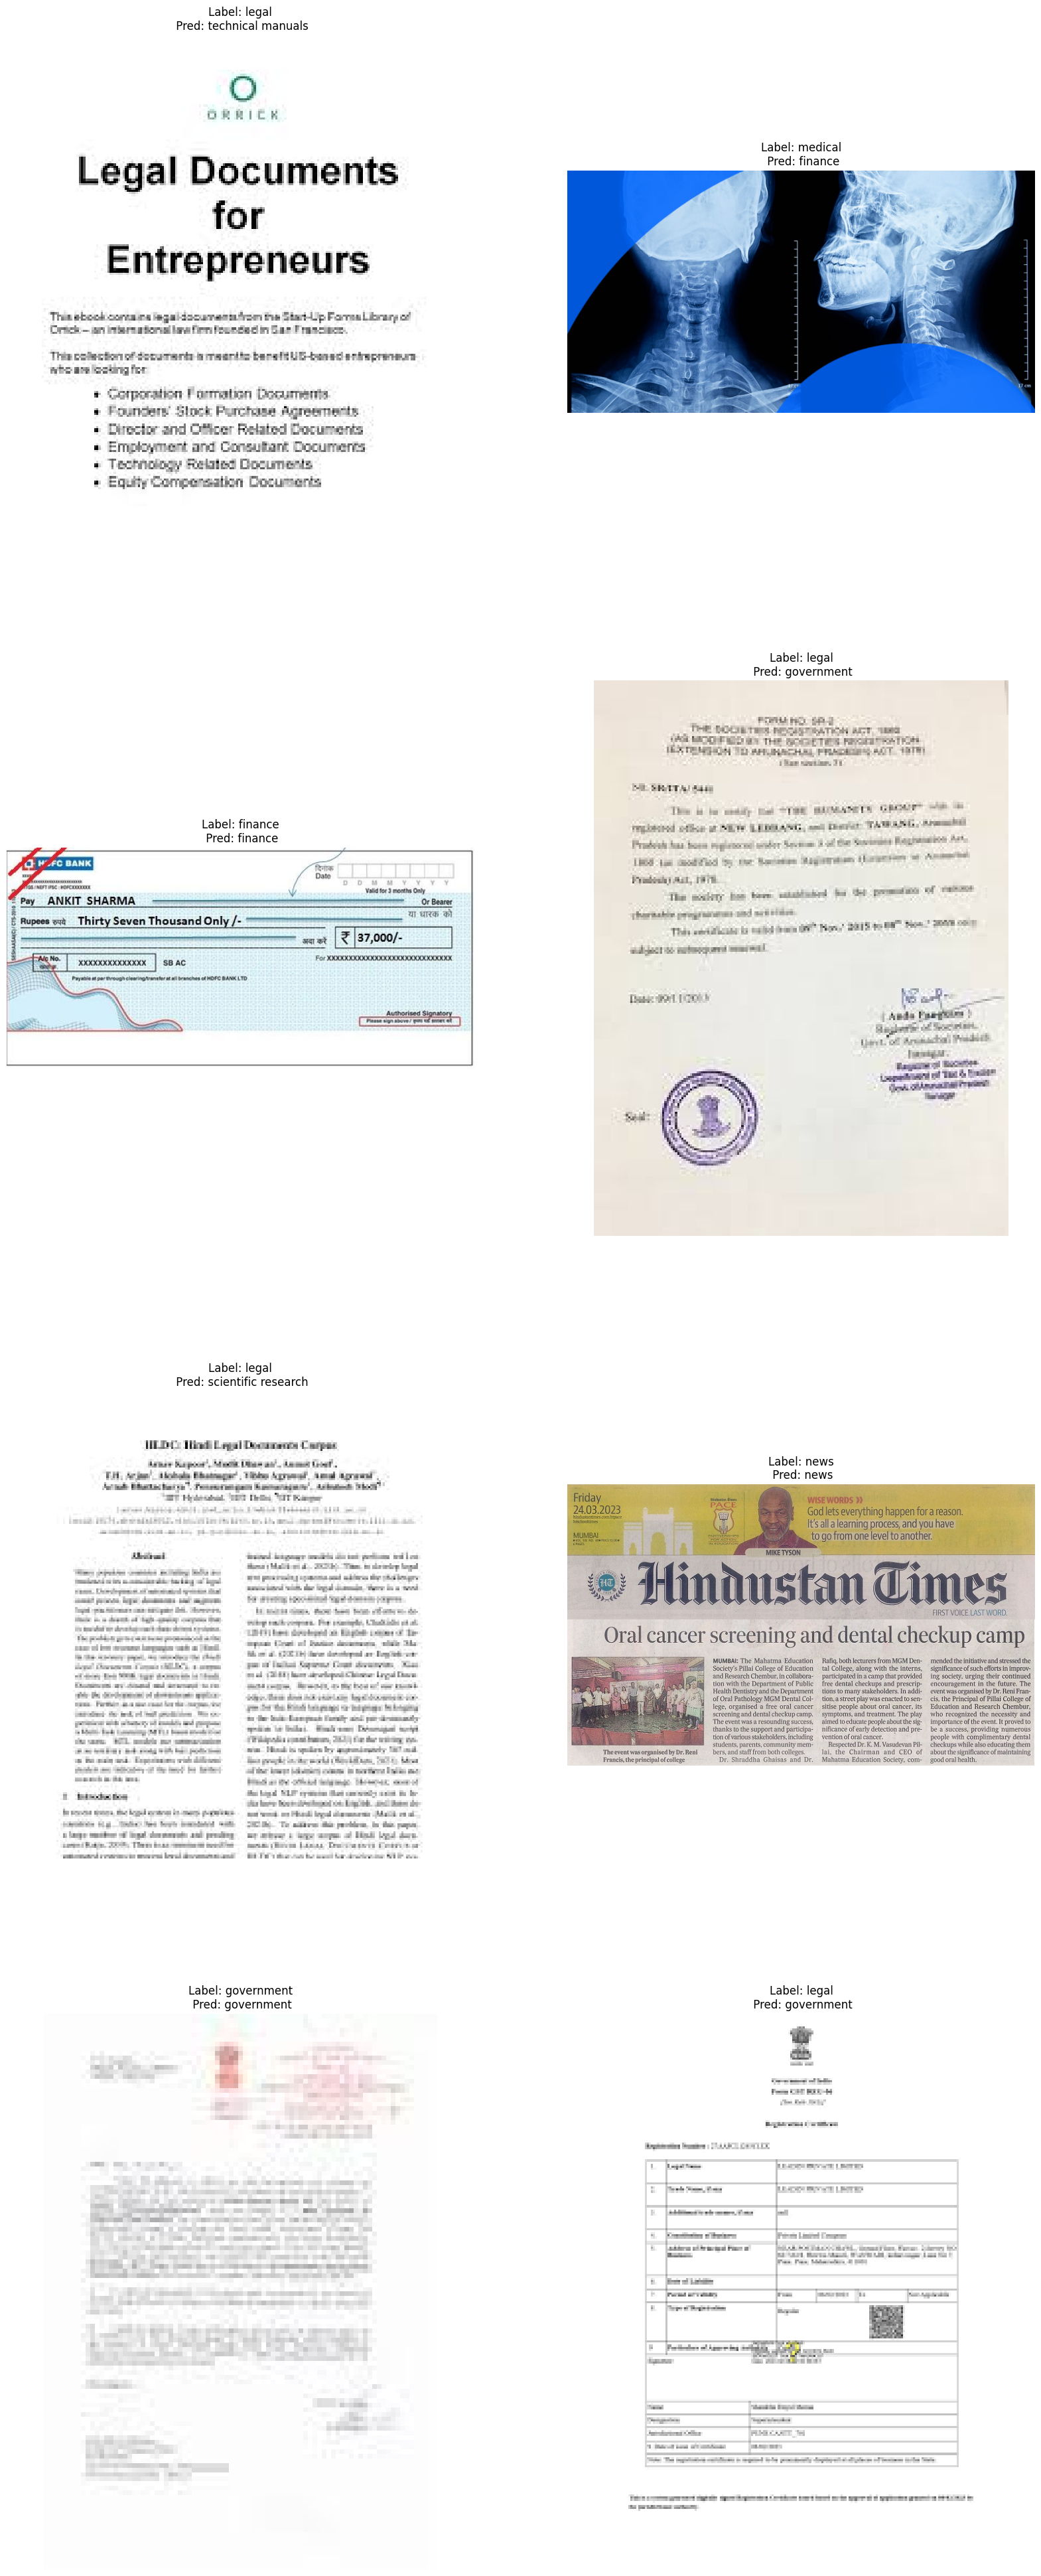

In [63]:
num_test = 8
cnt = 1

plt.figure(figsize=(20,50))
while cnt<=8:
    k = np.random.randint(len(test_data))
    label = test_data.label.iloc[k]
    im = Image.open(test_data.image_path.iloc[k]).convert("RGB")
    try:
        pred = infer(im, id_to_label, model, processor)
    except Exception as e:
        continue

    plt.subplot(int(num_test/2),2,cnt)
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Label: {label}\n Pred: {pred}")
    cnt += 1

plt.show()
